# Evaluation of all the (binary) models to detect defects in steel sheet 

### 1. Requirments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import models as c_models

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import (f1_score, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             recall_score, 
                             precision_score)

### 2. Parameters

In [2]:
MODEL_PATHS = ['../model/OfficialBinaryModels/' + i for i in os.listdir('../model/OfficialBinaryModels')]

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/binaryData'
METADATA_PATH = '../data/binaryData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test_binary.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test_binary.pth'

In [3]:
N_CLASSES = 2
N_MODEL = len(MODEL_PATHS)
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [4]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [5]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

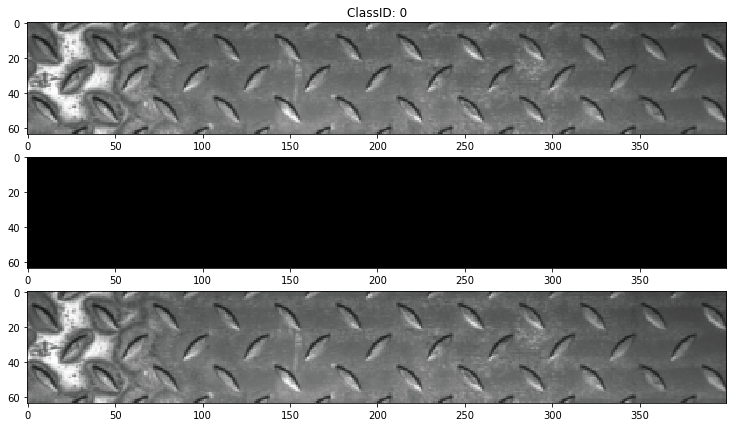

In [6]:
n = 1

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
mask = M_val[n].reshape(*params['size'])
ax[0].set_title('ClassID: {}'.format(y_val[n]))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
img[mask == 1] = img[mask == 1] + params['colors'][y_val[n]]
ax[2].imshow(img)
plt.show()

### 4. Model

    a) Load SqueezeNet architecture
    b) Modify the classifier architecture for each model
    c) Load the parameters
    d) Move model in GPU

In [7]:
### 4.1 Load architecture
nets = []
for path in MODEL_PATHS:
    if 'Squeeze' in path:
        net = models.squeezenet1_1(pretrained=True)
        if 'Reduced10' in path:
            net.features = net.features[:10]
            net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
        elif 'Reduced9' in path:
            net.features = net.features[:9]
            net.classifier[1] = nn.Conv2d(256, 1000, kernel_size = (1, 1), stride = (1, 1))
        net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, N_CLASSES))#, nn.Softmax(dim=1))
        net = net.to(device)
    elif 'CNN' in path:
        net = c_models.CNN(N_CLASSES).to(device)
    elif 'VGG' in path:
        vgg16 = models.vgg16_bn(pretrained=True)
        vgg16.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=256, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=256, out_features=32, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=32, out_features=N_CLASSES, bias=True))
        net = vgg16.to(device)
    else:
        print('{} not found'.format(path))
    net.load_state_dict(torch.load(path))
    nets.append(net)

### 5. Evaluation

    a) Compute the predicted labels and probabilities
    b) Compute metrics
    d) Plot ROC and Confusion Matrix

In [8]:
ys_pred, ys_true, ys_score, times = [], [], [], []
for net in nets:
    partial_time = time.time()
    y_pred = []
    y_true = []
    y_score = torch.Tensor([])
    batch_size = 5

    with torch.no_grad():
        net.eval()
        for n in tqdm(range(X_val.shape[0]//batch_size)):
            X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
            out = net(X)
            probs = nn.Softmax(dim=1)(out).detach().cpu()

            y_score = torch.cat([y_score, probs])
            y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
            y_true = np.concatenate([y_true, y.cpu().numpy()])
        
        X, y = X_val[(n+1)*batch_size:].to(device), y_val[(n+1)*batch_size:].to(device).long()
        out = net(X)
        probs = nn.Softmax(dim=1)(out).detach().cpu()

        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])

        

    times.append((time.time()-partial_time)/(X_val.shape[0]//batch_size))
    ys_true.append(y_true)
    ys_pred.append(y_pred)
    ys_score.append(y_score.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [01:25<00:00,  5.90it/s]


In [9]:
acc, bal_acc, f1_m, f1_w = [], [], [], []
for i in range(N_MODEL):
    acc.append(accuracy_score(ys_true[i], ys_pred[i]))
    bal_acc.append(balanced_accuracy_score(ys_true[i], ys_pred[i]))
    f1_m.append(f1_score(ys_true[i], ys_pred[i], average='macro'))
    f1_w.append(f1_score(ys_true[i], ys_pred[i]))
    
df = pd.DataFrame([acc, bal_acc, f1_m, f1_w], 
                  index=['Accuracy', 'Balanced Accuracy', 'F1 (macro)', 'F1 (binary)'],
                  columns = [i.split('/')[-1][:-4] for i in MODEL_PATHS]).transpose()

df['Metric Average'] = df.mean(axis=1)
df['Evaluation time (second/BatchSize)'] = np.array(times)*1000
df = df.round(3)
df.head(10)

,Accuracy,Balanced Accuracy,F1 (macro),F1 (binary),Metric Average,Evaluation time (second/BatchSize)
AugmentedCNN,0.875,0.872,0.874,0.887,0.877,20.938
AugmentedSqueezeReduced10,0.939,0.938,0.939,0.942,0.939,17.062
AugmentedSqueezeReduced9,0.923,0.922,0.922,0.928,0.924,13.421
CNN,0.887,0.885,0.886,0.895,0.888,9.584
Squeeze,0.939,0.937,0.938,0.943,0.939,19.453
SqueezeReduced10,0.930,0.931,0.930,0.933,0.931,14.271
VanillaSqueeze,0.832,0.828,0.829,0.851,0.835,18.904
VanillaVGG16,0.910,0.910,0.910,0.914,0.911,169.536
VGG16,0.941,0.942,0.941,0.944,0.942,169.832


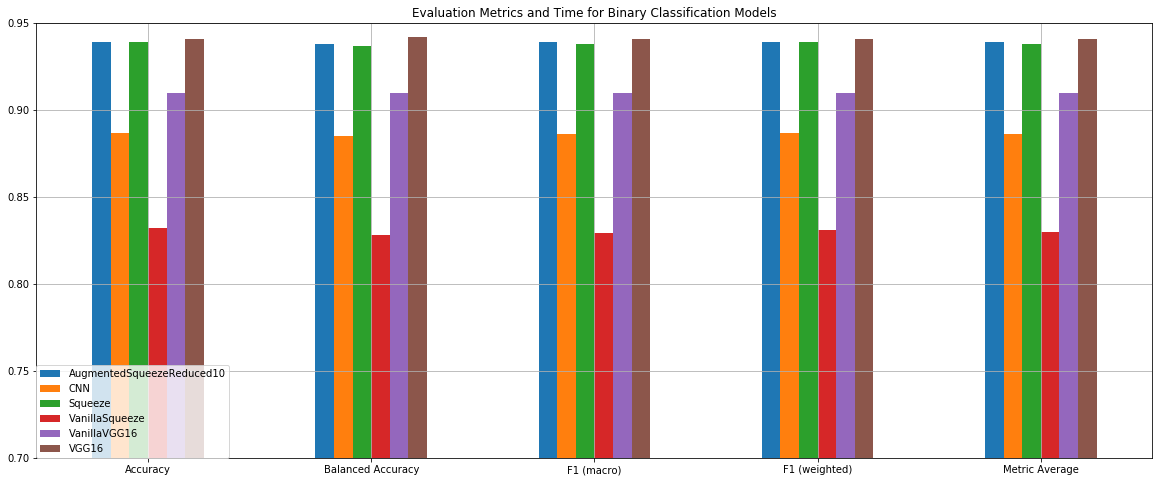

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
df.iloc[[1, 3, 4, 6, 7, 8], :-1].transpose().plot.bar(ax=ax)
ax.grid()
ax.set_ylim(0.70, 0.95)
ax.tick_params(axis='x', labelrotation = 0)
ax.set_yticks([i*0.1*0.5 for i in range(14, 20)])#, [i*0.1 for i in range(11)])

plt.title('Evaluation Metrics and Time for Binary Classification Models')
ax.legend(loc=[0.0, 0.0])
plt.show()

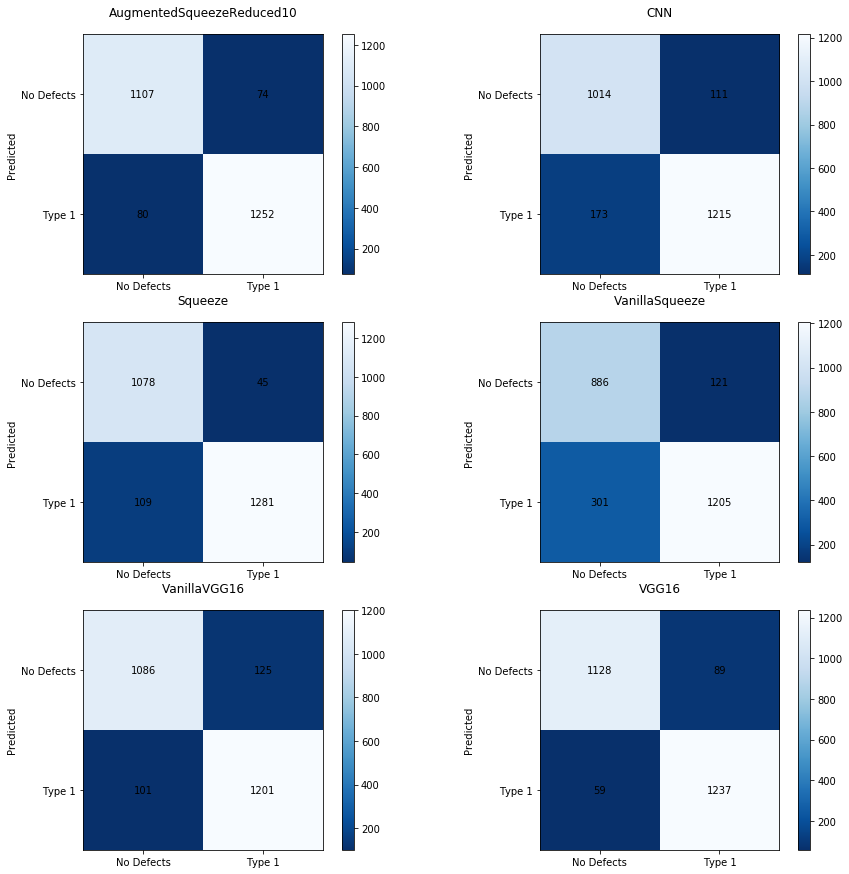

In [15]:
fig = plt.figure(figsize = (15, 15))
#plt.title('Confusion Matrix')
#for i in range(N_MODEL):
for j, i in enumerate([1, 3, 4, 6, 7, 8]):
    ax = fig.add_subplot(3, 2, j+1)
    cm = confusion_matrix(ys_pred[i], ys_true[i])
    cm_plot = ax.matshow(cm, cmap='Blues_r')
    ax.set_title(df.index[i])
    ax.set_ylabel('Predicted')
    ax.set_yticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
    plt.colorbar(cm_plot)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
    for i in range(N_CLASSES):
        for j in range(N_CLASSES):
            k = 0
            ax.text(j, i, cm[i, j], va='center', ha='center')

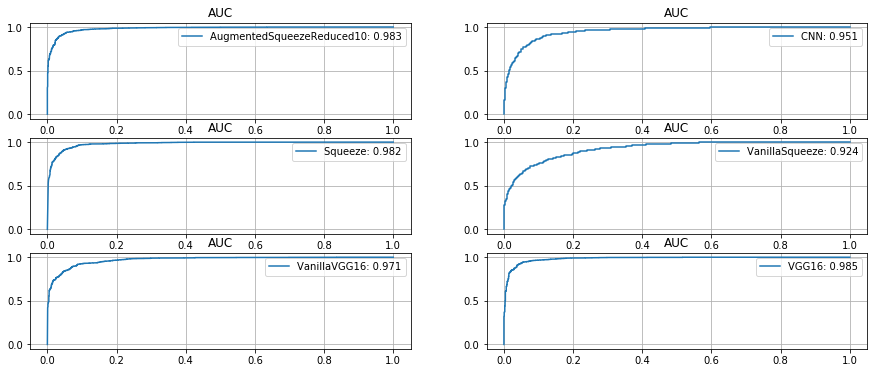

In [25]:
fig = plt.figure(figsize = (15, 6))
for j, i in enumerate([1, 3, 4, 6, 7, 8]):
    ax = fig.add_subplot(3, 2, j+1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[i], tpr[i], _ = roc_curve(ys_true[i], ys_score[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i], tpr[i], label='{}: {:.3f}'.format(df.index[i], roc_auc[i]))
    ax.grid()
    ax.set_title('AUC')
    ax.legend()